In [1]:
import numpy as np
import cv2
import glob
import os
import matplotlib.pyplot as plt

In [2]:
filepath = '/home/caio/models/png/'
lst = glob.glob(filepath+'*.png')
lst = sorted(lst,key=lambda x : int(os.path.split(x)[1][:-4]))

Reads all png images in the folder, and apply a simple binary thresholding on the red channel of these images. All images are stored in the imgs array:

In [3]:
imgs = [cv2.threshold(cv2.imread(im)[:,:,2],127,255,cv2.THRESH_BINARY)[1] for im in lst] 

Throws away unwanted parts of the images:

In [4]:
init = int(imgs[25].shape[1]/4)
end = int(imgs[25].shape[1]/4*3)
imgs = [img[:,init:end] for img in imgs]

Selects the min and max row and column indices where the last image is white:

In [5]:
minrow = np.argwhere(np.amax(imgs[-1],axis=1)).min()
maxrow = np.argwhere(np.amax(imgs[-1],axis=1)).max()
mincol = np.argwhere(np.amax(imgs[-1],axis=0)).min()
maxcol = np.argwhere(np.amax(imgs[-1],axis=0)).max()

Slices all images so we retrieve the desired region in all images:

In [6]:
imgs = [img[minrow:maxrow,mincol:maxcol] for img in imgs]

Plots some of the images to showcase the evolution of the coverage:

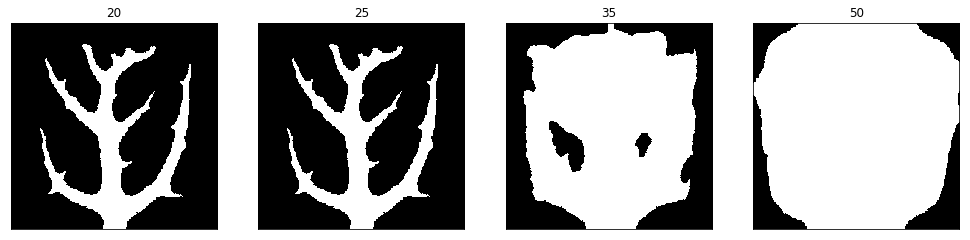

In [7]:
titles = ['20','25','35','50']
imindx = [25,25,35,50]

fig = plt.figure(figsize=(17,5))
for i,im in enumerate(imindx):
    plt.subplot(1,4,i+1),plt.imshow(imgs[im],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

Gets the area coverage and the coverage derivative using the images. Below, we plot these computed arrays. Note that we obtain nearly the same results, which we computed earlier using the paraview python scripts.

In [8]:
coverage = np.array([np.count_nonzero(img)/img.size for _, img in enumerate(imgs)])[20:]
coveragegrd = np.gradient(coverage)

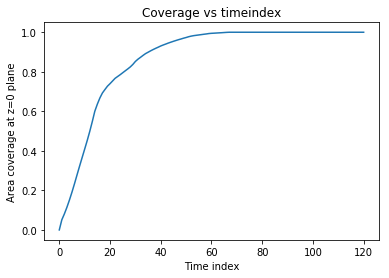

In [9]:
plt.plot(coverage)
plt.title('Coverage vs timeindex')
plt.ylabel('Area coverage at z=0 plane')
plt.xlabel('Time index')
plt.show()

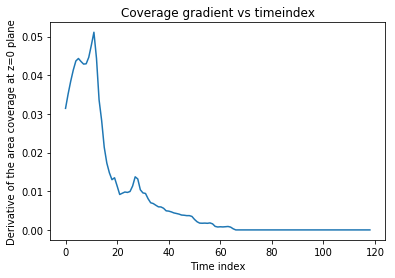

In [10]:
plt.plot(coveragegrd[2:])
plt.title('Coverage gradient vs timeindex')
plt.ylabel('Derivative of the area coverage at z=0 plane')
plt.xlabel('Time index')
plt.show()

In [11]:
cv2.imshow('image',imgs[19])
cv2.waitKey(0)
cv2.destroyAllWindows()